- The following practice assignment is much longer than a typical practice assignment. 
- You may skip this assignment if you feel comfortable with what you have learned thus far. 
- Note: while the target grades (G1-G3) are different, all of the features from this data set are the same as those from the Student Performance lessons. They require the same preprocessing steps as you've seen in the previous lessons.
# The Task
- Create a classification model to predict if a student will Pass or Fail their final Math Grade (G3).
- Apply the same binning as the lesson to determine the classification target.
- Evaluate its performance on the training and test data.
  - Note: these grades are more difficult to predict than the Portuguese grades featured in the lessons. Do not fret too much about your model's performance (expect ~70-80% accuracy).
- Extract and visualize coefficients or feature importance (depending on the model type selected).
- Apply the SHAP package and create a summary plot of the SHAP values for your model.
- Interpret the effects of the top 5 most important features, according to SHAP.
## The Data
- Student Performance - Math
Share URL Direct Link:
https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx
  - Note: the dataset is an Excel document, and you will need to specify that sheet_name='student-mat' in pd.read_excel
- Data Dictionary:
https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
# plt.style.use(['fivethirtyeight','seaborn-talk'])
# mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.base import clone

## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-mat')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [3]:
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()

0    30.0
1    30.0
2    50.0
3    75.0
4    50.0
Name: G3(%), dtype: float64

In [4]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)

0      F
1      F
2      F
3      C
4      F
      ..
390    F
391    C
392    F
393    F
394    F
Name: G3(%), Length: 395, dtype: category
Categories (5, object): ['F' < 'D' < 'C' < 'B' < 'A']

In [5]:
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,30.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,30.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,50.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,75.0,C
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,50.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9,45.0,F
391,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,14,16,16,80.0,C
392,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7,35.0,F
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10,50.0,F


In [6]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(1)

True     0.668354
False    0.331646
Name: target_F, dtype: float64

## Preprocessing

In [7]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [8]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001E2DE8E1D90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001E2D7FF2C40>)],
                  verbose_feature_names_out=False)

In [9]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
58,15.0,1.0,2.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
338,18.0,3.0,3.0,1.0,4.0,0.0,5.0,3.0,3.0,1.0,1.0,1.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
291,17.0,4.0,3.0,1.0,3.0,0.0,4.0,2.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [10]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")

    ## training data
    print(f"[i] Training Data:")
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize, 
                                                  cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()
    
    
    print(dashes)
    ## training data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize, 
                                                  cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

## Model - RandomForest

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       101
        True       1.00      1.00      1.00       195

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



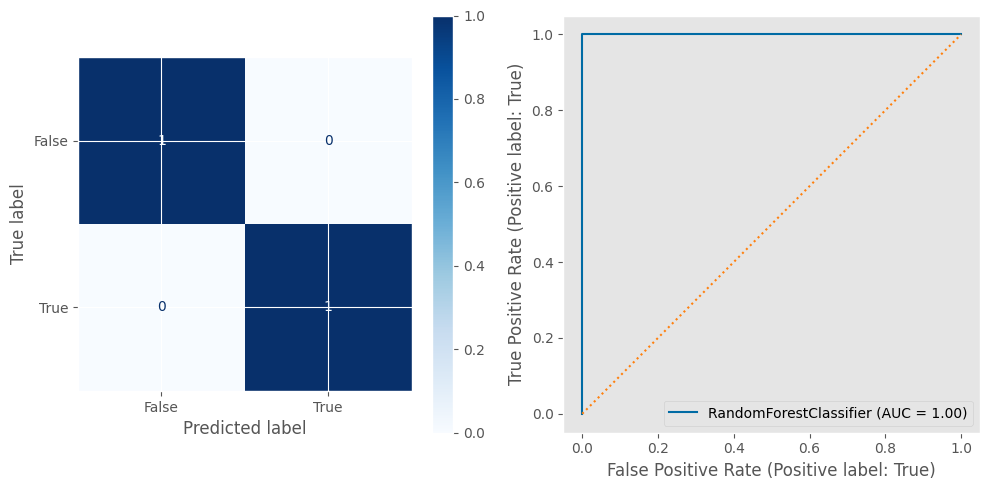

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.77      0.33      0.47        30
        True       0.77      0.96      0.85        69

    accuracy                           0.77        99
   macro avg       0.77      0.64      0.66        99
weighted avg       0.77      0.77      0.73        99



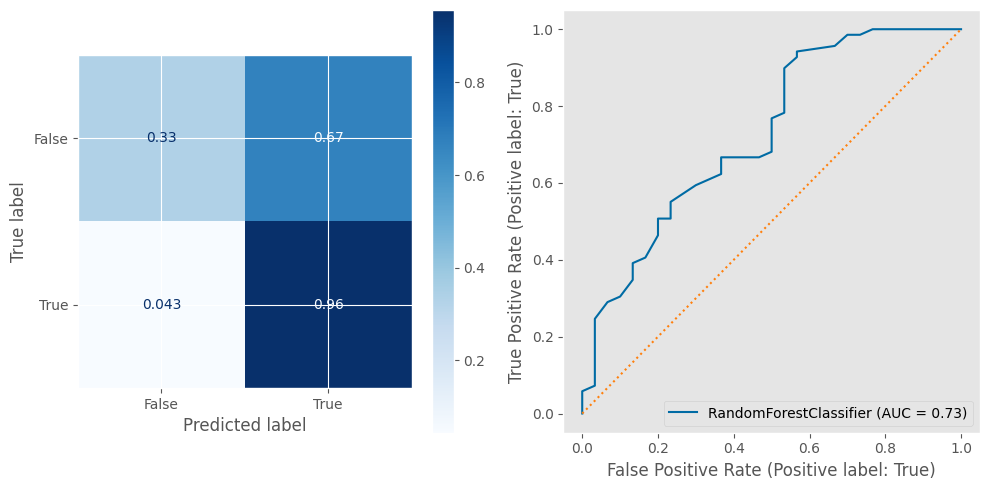

In [11]:
## fit random fores
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

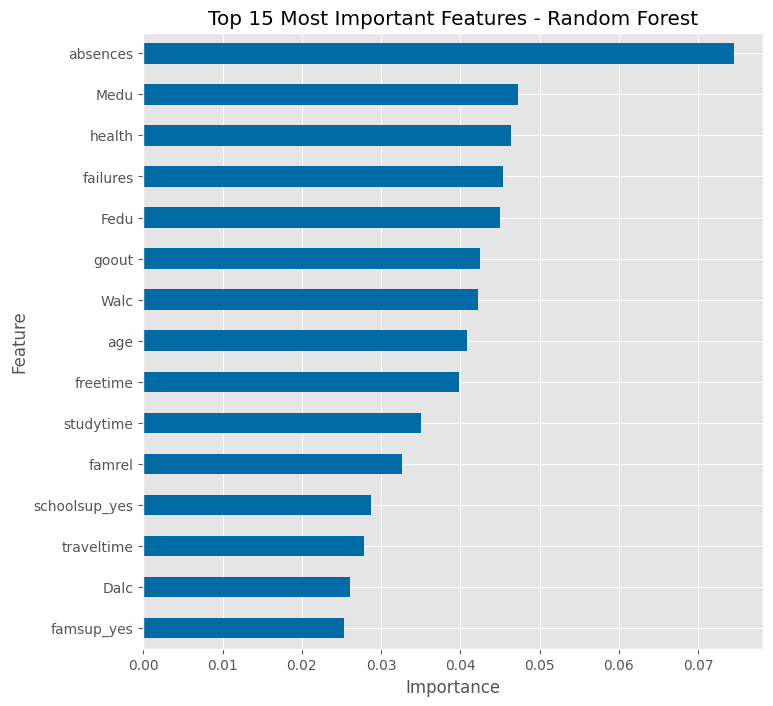

In [12]:
## Saving the feature importances
importances = pd.Series(rf_clf.feature_importances_, index= feature_names,
                       name='RandomForest Feature Importance')
ax = importances.sort_values().tail(15).plot(kind='barh',figsize=(8,8))
ax.set(title='Top 15 Most Important Features - Random Forest',
       ylabel='Feature', xlabel='Importance');

In [13]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [14]:
X_shap = shap.sample(X_train_df,nsamples=200,random_state=321)
X_shap

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
355,18.0,3.0,3.0,1.0,2.0,0.0,5.0,3.0,4.0,1.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
354,17.0,4.0,3.0,2.0,2.0,0.0,4.0,5.0,5.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
328,17.0,4.0,4.0,1.0,3.0,0.0,5.0,4.0,4.0,1.0,3.0,4.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
231,17.0,2.0,2.0,2.0,2.0,0.0,4.0,5.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
312,19.0,1.0,2.0,1.0,2.0,1.0,4.0,5.0,2.0,2.0,2.0,4.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,19.0,3.0,3.0,1.0,4.0,0.0,4.0,3.0,3.0,1.0,2.0,3.0,10.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
236,17.0,2.0,2.0,1.0,2.0,0.0,4.0,4.0,2.0,5.0,5.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
10,15.0,4.0,4.0,1.0,2.0,0.0,3.0,3.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
13,15.0,4.0,3.0,2.0,2.0,0.0,5.0,4.0,3.0,1.0,2.0,3.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [15]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index].astype(int)
y_shap 

355    1
354    1
328    1
231    1
312    1
      ..
210    1
236    0
10     1
13     1
372    1
Name: target_F, Length: 200, dtype: int32

In [16]:
explainer = shap.Explainer(rf_clf)
explainer

In [17]:
## Getting the shap values
shap_values = explainer(X_shap)
shap_values.shape

(200, 43, 2)

In [18]:
shap_vals_F = shap_values[:,:,1]
shap_vals_F.shape

(200, 43)

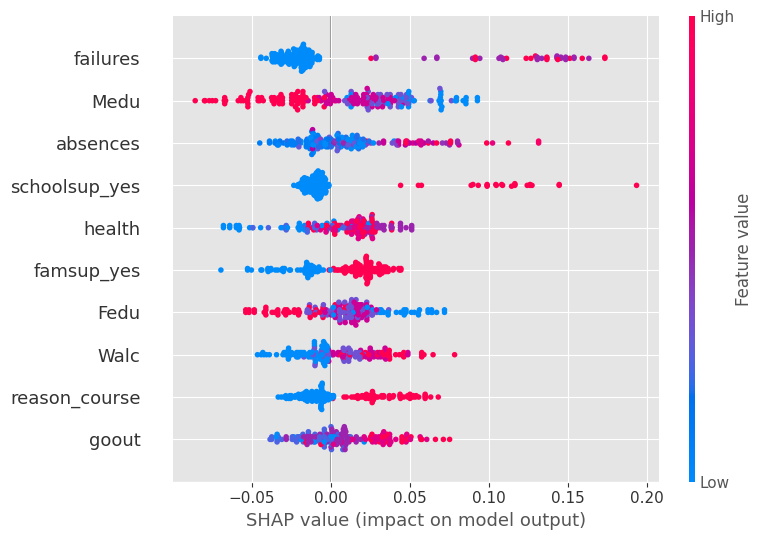

In [19]:
shap.summary_plot(shap_vals_F,max_display=10)

## Top 5 Most Important Features:
1. Failures:

 - The more failures the more likely the model will predict a Failing grade.
2. Medu:

 - The higher the mother's education level the less likely the model will predict a Failing grade.
3. absences:

  - The more absences the more likely the model will predict a Failing grade.
4. schoolsup_yes:

  - students who receive additional school support are more likely to be a predicted Failure.
5. health:

  - The healthier the student is, the more likely the model will predict a Failing grade.

## Model - LogisticRegression

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       0.71      0.54      0.61       101
        True       0.79      0.88      0.83       195

    accuracy                           0.77       296
   macro avg       0.75      0.71      0.72       296
weighted avg       0.76      0.77      0.76       296



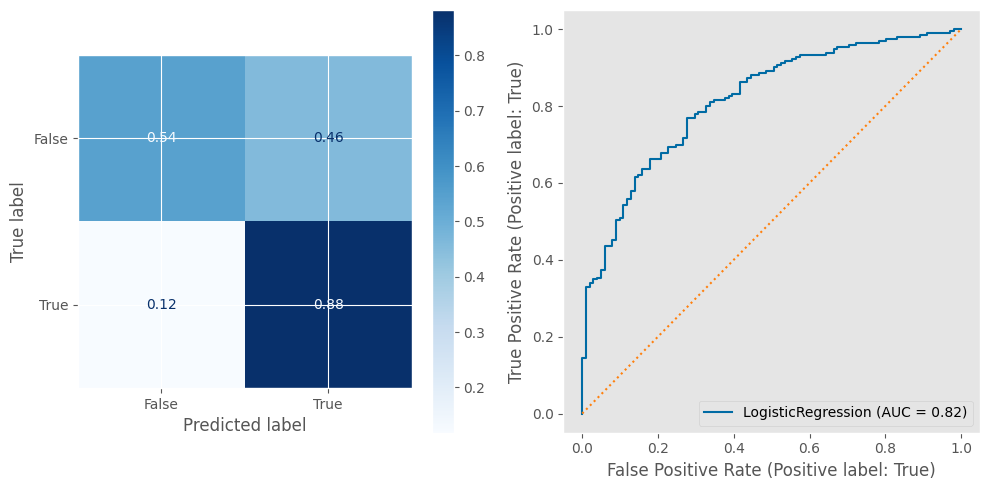

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.52      0.40      0.45        30
        True       0.76      0.84      0.80        69

    accuracy                           0.71        99
   macro avg       0.64      0.62      0.63        99
weighted avg       0.69      0.71      0.69        99



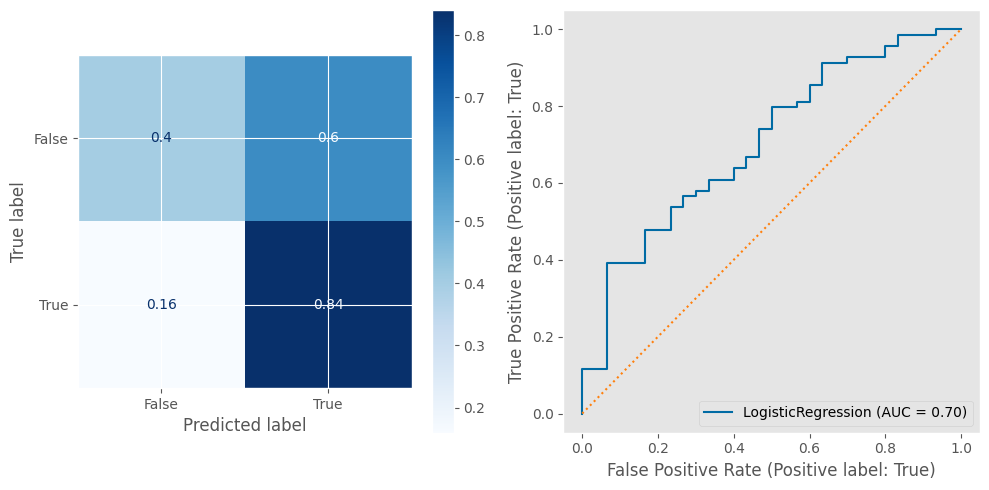

In [20]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)#,class_weight='balanced')
log_reg.fit(X_train_df,y_train)
evaluate_classification(log_reg,X_train_df,y_train, X_test_df,y_test)

In [21]:
explainer = shap.Explainer(log_reg.predict, X_shap)
explainer

In [22]:
## Getting the shap values
shap_values = explainer(X_shap)
shap_values.shape

(200, 43)

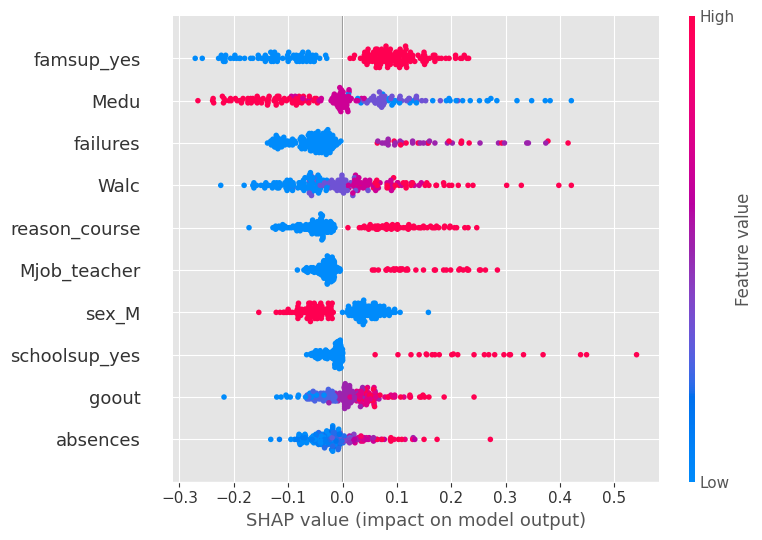

In [23]:
shap.summary_plot(shap_values,max_display=10)

## Top 5 Most Important Features:
1. famsup_yes:

  - If the student is receiving supplemental support from their family, they are more likely to be predicted to Fail.
2. Medu:

  - The higher the mother's education level the less likely the model will predict a Failing grade.
3. failures:

  - The more failures the student had in other courses the more likely the model predicted they would fail math.
4. Walc:

  - The greater the weekend alcohol consumption, the more likely the model will predict a Failing grade.
5. reason_course:

  - If a student is attending their school for a specific course, they are more likely to be predicted to Fail.